In [1]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

from skimage import io
from skimage.transform import resize
from skimage.color import rgb2lab, lab2rgb, rgb2gray

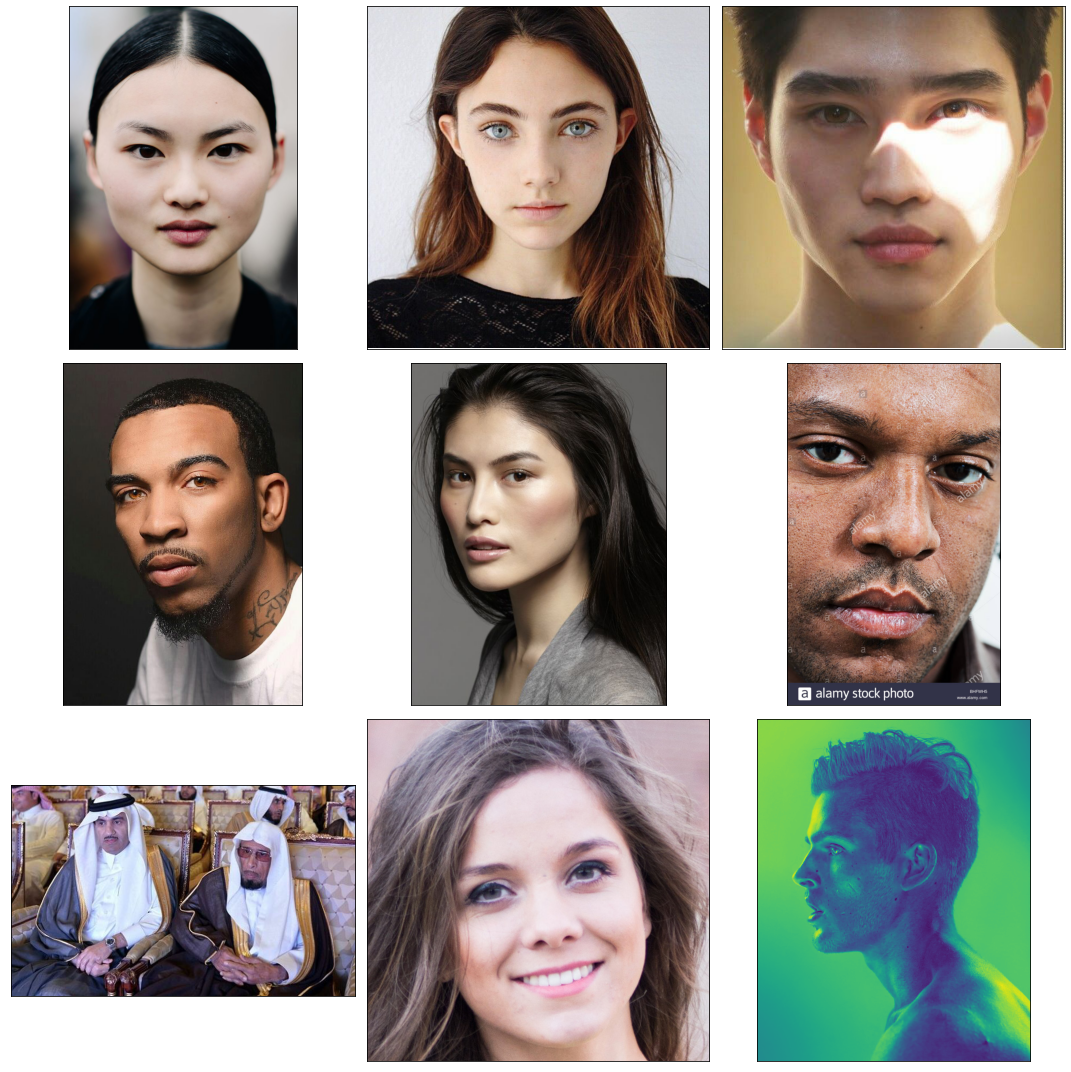

In [2]:
color_path = "../input/human-faces/Humans"
color_images = os.listdir(color_path)

# Randomly view 9 color images
size = 3
images = random.sample(color_images, size*size)
images = np.array(images)
images = images.reshape(size, size)

fig, axs = plt.subplots(size, size, figsize = (15, 15))
for i in range(size):
    for j in range(size):
        img_path = os.path.join(color_path, images[i, j])
        img = io.imread(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xticks = [], yticks = [])

fig.tight_layout()

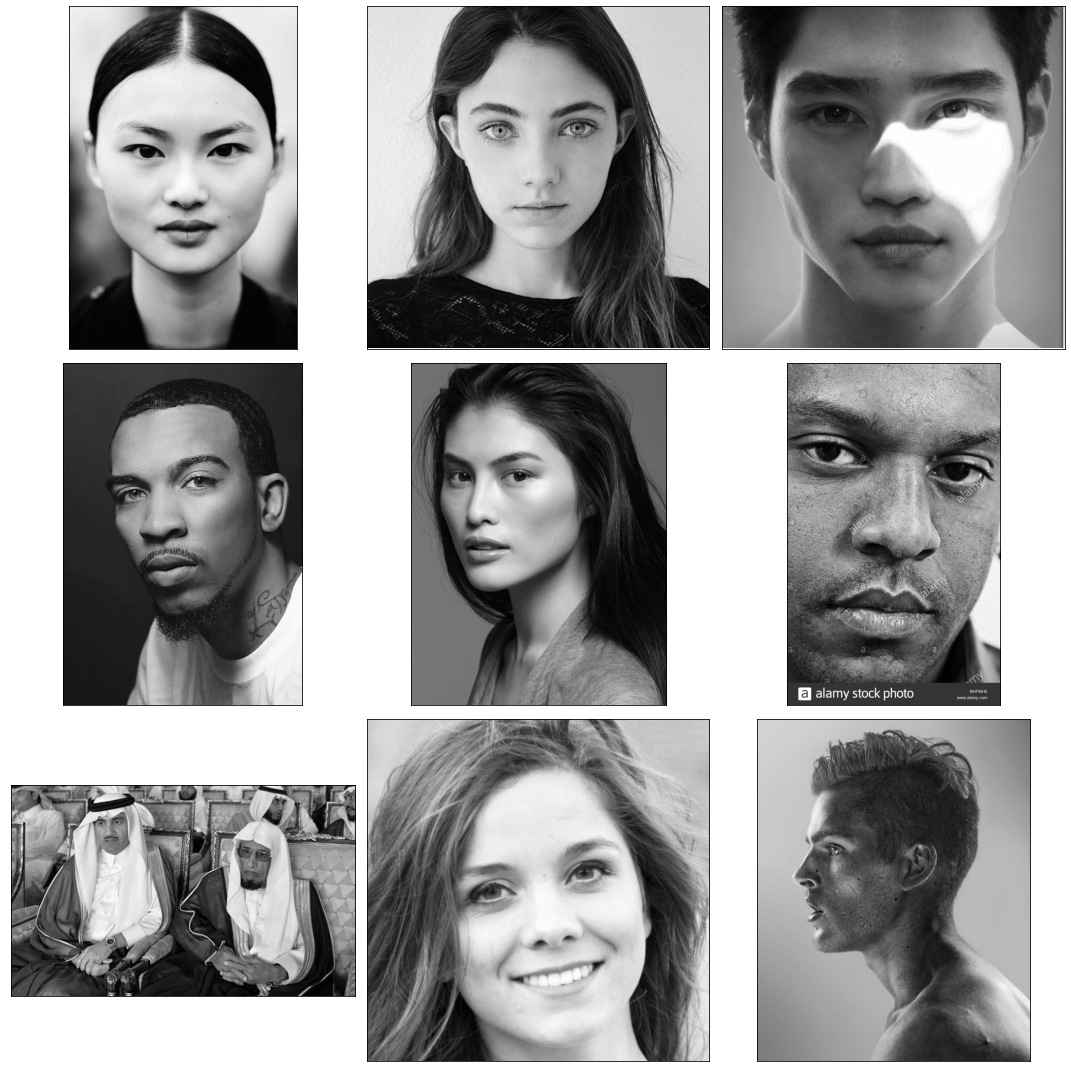

In [3]:
# View 9 black-white images for the same random images
fig, axs = plt.subplots(size, size, figsize = (15, 15))
for i in range(size):
    for j in range(size):
        img_path = os.path.join(color_path, images[i, j])
        img = io.imread(img_path)
        img = rgb2gray(img)
        axs[i, j].imshow(img, cmap = plt.cm.gray)
        axs[i, j].set(xticks = [], yticks = [])

fig.tight_layout()

In [4]:
# Build image data generator 
train_datagen = ImageDataGenerator(
    rescale = 1./255 # Normalization
)

# Obtain all images from directory
batch_size = 1200
target_size = 256
train = train_datagen.flow_from_directory(
    "../input/human-faces", 
    target_size = (target_size, target_size),
    batch_size = batch_size
)

Found 7219 images belonging to 1 classes.


In [5]:
# Convert rgb images to lab
X = []
Y = []
for img in train[0]:
    try:
        lab = rgb2lab(img)
        X.append(lab[:, :, :, 0])
        Y.append(lab[:, :, :, 1:] / 128)
    except:
        print("error")

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:952: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


error


In [6]:
# Reshape arrays to suit model input
X = np.array(X)
Y = np.array(Y)

X = X.reshape(batch_size, target_size, target_size, -1)
Y = Y.reshape(batch_size, target_size, target_size, -1) 

print(X.shape)
print(Y.shape)

(1200, 256, 256, 1)
(1200, 256, 256, 2)


In [7]:
#Encoder
encoder_input = Input(shape = (256, 256, 1, ))
encoder_output = Conv2D( 64, (3, 3), activation = "relu", padding = "same", strides = 2)(encoder_input)
encoder_output = Conv2D(128, (3, 3), activation = "relu", padding = "same")(encoder_output)
encoder_output = Conv2D(128, (3, 3), activation = "relu", padding = "same", strides = 2)(encoder_output)
encoder_output = Conv2D(256, (3, 3), activation = "relu", padding = "same")(encoder_output)
encoder_output = Conv2D(256, (3, 3), activation = "relu", padding = "same", strides = 2)(encoder_output)
encoder_output = Conv2D(512, (3, 3), activation = "relu", padding = "same")(encoder_output)
encoder_output = Conv2D(512, (3, 3), activation = "relu", padding = "same")(encoder_output)
encoder_output = Conv2D(256, (3, 3), activation = "relu", padding = "same")(encoder_output)

#Decoder
decoder_output = Conv2D(128, (3, 3), activation = "relu", padding = "same")(encoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D( 64, (3, 3), activation = "relu", padding = "same")(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D( 32, (3, 3), activation = "relu", padding = "same")(decoder_output)
decoder_output = Conv2D( 16, (3, 3), activation = "relu", padding = "same")(decoder_output)
decoder_output = Conv2D(  2, (3, 3), activation = "tanh", padding = "same")(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

# Model
model = Model(inputs = encoder_input, outputs = decoder_output)

In [8]:
# Compile model
model.compile(
    optimizer = "adam", 
    loss = "mse", 
    metrics = ['accuracy']
)

In [9]:
# View model and it's parameters
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 256)       590080    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 512)      

In [10]:
# Fit the model (mapping input image to output image)
history = model.fit(
    X, Y,
    epochs = 150,
    callbacks = [
        ModelCheckpoint("model_weights.h5")
    ]
)

Epoch 1/150
38/38 [==============================] - 7s 195ms/step - loss: 0.0379 - accuracy: 0.5797
Epoch 2/150
38/38 [==============================] - 7s 182ms/step - loss: 0.0064 - accuracy: 0.6691
Epoch 3/150
38/38 [==============================] - 7s 176ms/step - loss: 0.0061 - accuracy: 0.6710
Epoch 4/150
38/38 [==============================] - 7s 175ms/step - loss: 0.0061 - accuracy: 0.6699
Epoch 5/150
38/38 [==============================] - 7s 176ms/step - loss: 0.0058 - accuracy: 0.6685
Epoch 6/150
38/38 [==============================] - 7s 180ms/step - loss: 0.0057 - accuracy: 0.6603
Epoch 7/150
38/38 [==============================] - 7s 178ms/step - loss: 0.0058 - accuracy: 0.6492
Epoch 8/150
38/38 [==============================] - 7s 176ms/step - loss: 0.0058 - accuracy: 0.6661
Epoch 9/150
38/38 [==============================] - 7s 176ms/step - loss: 0.0057 - accuracy: 0.6605
Epoch 10/150
38/38 [==============================] - 7s 179ms/step - loss: 0.0056 - accura

38/38 [==============================] - 7s 175ms/step - loss: 8.9571e-04 - accuracy: 0.7797
Epoch 82/150
38/38 [==============================] - 7s 177ms/step - loss: 8.8390e-04 - accuracy: 0.7769
Epoch 83/150
38/38 [==============================] - 7s 178ms/step - loss: 8.7000e-04 - accuracy: 0.7769
Epoch 84/150
38/38 [==============================] - 7s 175ms/step - loss: 8.3882e-04 - accuracy: 0.7819
Epoch 85/150
38/38 [==============================] - 7s 178ms/step - loss: 8.9647e-04 - accuracy: 0.7775
Epoch 86/150
38/38 [==============================] - 7s 177ms/step - loss: 8.7419e-04 - accuracy: 0.7795
Epoch 87/150
38/38 [==============================] - 7s 176ms/step - loss: 8.5993e-04 - accuracy: 0.7773
Epoch 88/150
38/38 [==============================] - 7s 177ms/step - loss: 8.7182e-04 - accuracy: 0.7761
Epoch 89/150
38/38 [==============================] - 7s 175ms/step - loss: 8.1613e-04 - accuracy: 0.7846
Epoch 90/150
38/38 [==============================] - 7s 17

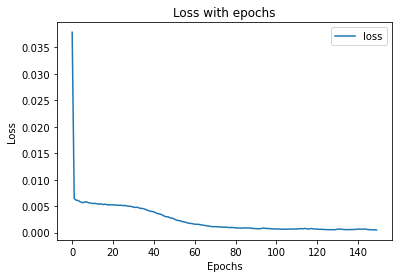

In [11]:
# Plot loss curve
plt.plot(history.history["loss"])
plt.legend(["loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss with epochs")
plt.show()

[[], [], Text(0.5, 0, 'Colorized Image (output)')]

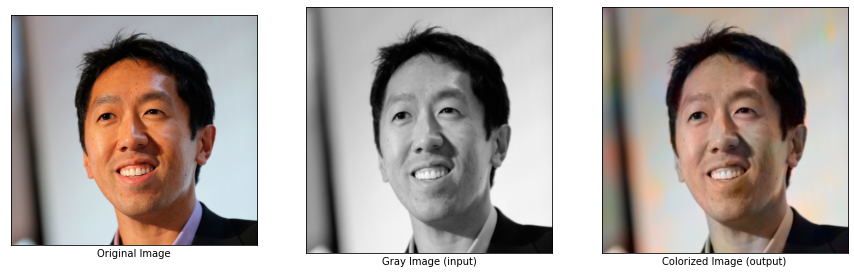

In [12]:
# Visualizing original, input and output images
fig, axs = plt.subplots(1, 3, figsize = (15, 5))

# Plot original image
original_img = io.imread("../input/andrew-ng/andrew.jpg")
axs[0].imshow(original_img)
axs[0].set(xlabel = "Original Image", xticks = [], yticks = [])

# Plot gray image (input)
img = original_img/255.
img = resize(img, (target_size, target_size, 3))
img = rgb2lab(img)
gray_img = img[:, :, 0]
axs[1].imshow(gray_img, cmap = plt.cm.gray)
axs[1].set(xlabel = "Gray Image (input)", xticks = [], yticks = [])

# Make prediction on the input to get output
gray_img = gray_img.reshape(1, target_size, target_size, -1)
pred = model.predict(gray_img)
pred = pred.reshape(target_size, target_size, 2)
gray_img = gray_img.reshape(target_size, target_size, 1)

# Plot colorized image (output)
result = np.zeros((target_size, target_size, 3))
result[:, :, 0] = gray_img[:, :, 0]
result[:, :, 1:] = pred*128
result = lab2rgb(result)
axs[2].imshow(result)
axs[2].set(xlabel = "Colorized Image (output)", xticks = [], yticks = [])

In [14]:
# Save model for future use
model.save("color_model") 